
Earth-Moon orbital radius: $380 \times 10^3$ km

Earth-Moon orbital period: $27.3$ days

Earth-Sun orbital radius: $(149 \times 10^3) \times 10^3$ km

Earth-Sun orbital period: $365.25$ days

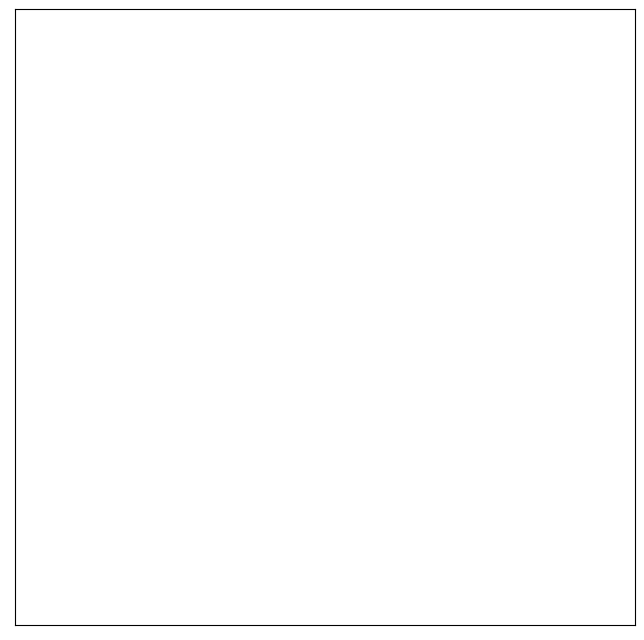

In [1]:
from matplotlib import animation
from matplotlib.animation import PillowWriter
import matplotlib.pyplot as plt
import numpy as np


class OOPlanet:
    def __init__(self, radius, angularfreq):
        self.radius = radius
        self.angularfreq = angularfreq
        
    def getangularfreq(self):
        return self.angularfreq
    
    def getradius(self):
        return self.radius
        
    def getX(self, time):
        return self.radius * np.cos(self.angularfreq * time)
    
    def getY(self, time):
        return self.radius * np.sin(self.angularfreq * time)
    
    def position(self, time):
        return (self.getX(time), self.getY(time))
        
    def planetevolve(self, start, end, timestep):
        tinterval = end - start
        resolution = tinterval // timestep
        xarray = []
        yarray = []
        t = start
        for i in range(resolution):
            xarray.append(self.position(t)[0])
            yarray.append(self.position(t)[1])
            t = t + timestep
        return [xarray, yarray]

class OOPmoon(OOPlanet): #subclass of OOPlanet
    def __init__(self, radius, angularfreq, radius2, angularfreq2): #radius2 and angularfreq2 are relative to earth
        super().__init__(radius, angularfreq)
        self.radius2 = radius2
        self.angularfreq2 = angularfreq2
    
    def getradius2(self):
        return self.radius2
    
    def getangularfreq2(self):
        return self.angularfreq2
    
    def getX(self, time):
        return super().getX(time) + (self.radius2 * np.cos(self.angularfreq2 * time))
    
    def getY(self, time):
        return super().getY(time) + (self.radius2 * np.sin(self.angularfreq2 * time))
                        
    def position(self, time):
        return (self.getX(time), self.getY(time))
    
    def moonevolve(self, start, end, timestep):
        tinterval = end - start
        resolution = tinterval // timestep
        xarray = []
        yarray = []
        t = start
        for i in range(resolution):
            xarray.append(self.position(t)[0])
            yarray.append(self.position(t)[1])
            t = t + timestep
        return [xarray, yarray]


# Initialising the 3 planets. We only create an instance of OOPlanet for Earth and another instance of OOPmoon for
# the moon. We do not need to initialise the sun because we are taking the origin to be sun and we the observer's
# frame of reference IS the sun's reference frame
earthsun_radius = 15
earthmoon_radius = 3

earth = OOPlanet(earthsun_radius, (2*np.pi)/365.25)
moon = OOPmoon(earthsun_radius, (2*np.pi)/365.25, earthmoon_radius, (2*np.pi)/27.3)

xe, ye = earth.planetevolve(0, 365, 1)[0], earth.planetevolve(0, 365, 1)[1]

xm, ym = moon.moonevolve(0, 365, 1)[0], moon.moonevolve(0, 365, 1)[1]

# plt.plot(xm, ym, '.', color = 'grey')
# plt.plot(xe, ye, '.', color = 'blue')


# Animating the plot
fig, ax = plt.subplots(1, 1, figsize = (8,8))
movingmoon, = plt.plot([], [], 'o', color = 'grey')
movingearth, = plt.plot([], [], 'o', color = 'blue')
time_text = ax.text(0.65, 0.95, '', fontsize=15,
                    bbox=dict(facecolor='white', edgecolor='black'), 
                    transform=ax.transAxes)

ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)
plt.xticks([], [])
plt.yticks([], [])

def animate(frame):
    plt.plot(0,0 ,'o', color = 'orange', markersize = 10)
    movingmoon.set_data(xm[frame], ym[frame])
    movingearth.set_data(xe[frame], ye[frame])
    time_text.set_text('t={:.2f} days'.format(frame))
    
ani = animation.FuncAnimation(fig, animate, frames = 365, interval = 1)
# ani.save('animation2.gif', writer = 'pillow', fps=30, dpi = 120)
    

The next two sections we will be writing code 
1. for simulating the Earth's orbit around the sun (2-bodies) and 
2. for simulating trajectories of 3 bodies that are gravitationally attracted to one another

Much of the code and logic is inspired by PhD candidate Luke Polson (link to video: https://www.youtube.com/watch?v=8_RRZcqBEAc&t=115s) 

# 2-Body

The previous program was a crude mathematical modelling of the SEM, the next program will try to incorporate the actual mathematical modelling of the trajectories of the SEM. However, before diving into the solving the 3-body problem and modelling the trajectories of SEM, we will first model a simpler version of SEM - the Sun-Earth system. As the name suggests, this is only a 2-body problem and will be simpler to solve. 

## Mathematical Preliminaries

By Newton's Law of Universal Gravitation,
\begin{equation}
{F} = -\frac{GMm}{r^2}
\end{equation}


By Newton's 2nd Law, since the net force on each of the bodies are just the gravitational forces on each other, we can write

\begin{equation}
\mathbf{F_\textrm{net}} = -\frac{GM_\textrm{S} m_\textrm{E}}{r^3}\mathbf{r}
\end{equation}

Then, the differential equation to be set up for the motion of Earth *(we will not write out equation of motion for the Sun for now)* is 
\begin{equation}
\frac{d^2\mathbf{r}}{{dt^2}} = -\frac{GM_\textrm{S}}{r^3}\mathbf{r}
\end{equation}

We can rewrite this differential equation into 2 coupled differential equations
\begin{align}
\frac{d\mathbf{r}}{dt} &= \mathbf{v} \\
\frac{d\mathbf{v}}{dt} &= -\frac{GM_\textrm{S}}{r^3}\mathbf{r}
\end{align}

In vector form,
\begin{equation}
\frac{d\mathbf{S}}{dt} = \begin{pmatrix}
\mathbf{v} \\
-\frac{GM_\textrm{S}}{r^3}\mathbf{r}
\end{pmatrix}
\end{equation}

where
\begin{equation}
\mathbf{S} = \begin{pmatrix}
\mathbf{r} \\
\mathbf{v}
\end{pmatrix}
\end{equation}

## Simplification

For the sake of simplification so that our computer will be performing calculations with nicer numbers, we will take $G = 1$ and $m_E = 1$ and initial seperation $r$ = 1. Therefore, the equation of motion for the Earth,

\begin{equation}
\frac{d\mathbf{v}}{dt} = -\frac{GM_\textrm{S}}{r^3}\mathbf{r}
\end{equation}

will be re-written as
\begin{align}
\frac{r_\text{initial}^3}{Gm_E}\frac{d^2\mathbf{r}}{{dt}^2}_\text{Earth} &= -\frac{M_\textrm{S}}{r^3}\mathbf{r} \\
\left\{\frac{d^2\mathbf{r}}{{dt}^2}\right\}_\text{Earth, for code} &= -\frac{M_\textrm{S}}{r^3}\mathbf{r}
\end{align}

Similarly, the equation of motion for the Sun is written out as

\begin{align}
\frac{r_\text{initial}^3}{Gm_E}\frac{d^2\mathbf{r}}{{dt}^2}_\text{Sun} &= -\frac{1}{r^3}\mathbf{r} \\
\left\{\frac{d^2\mathbf{r}}{{dt}^2}\right\}_\text{Sun, for code} &= -\frac{1}{r^3}\mathbf{r}
\end{align}

In essence, we have taken the original equation of motion for both the Sun and the Earth with their not-so-nice numbers and divided away those not-so-nice numbers so that the computer's calculations look prettier, while preserving all the physics.

In [59]:
import scipy.integrate as sp
# Earth-Sun Problem:
# taking mass of earth to be 1, mass of sun to be 330*10e3, initial separation to be 1,
def dSdt(S, t):
    xe, ye, xs, ys, vex, vey, vsx, vsy = S
    r = np.sqrt((xs - xe)**2 + (ys - ye)**2)
    return [vex, vey, vsx, vsy,
            ((330e3)/(r**3) * (xs - xe)), #earth acceleration x component
            ((330e3)/(r**3) * (ys - ye)), #earth acceleration y component
            ((1)/(r**3) * (xe - xs)), #sun acceleration x component
            ((1)/(r**3) * (ye - ys))] #sun acceleration y component

# array of time
t = np.linspace(0, 1, 10000)

xe0 = 1
ye0 = 0
xs0 = 0
ys0 = 0 
vex0 = 0
vey0 = np.sqrt(330e3)
vsx0 = 0
vsy0 = 0

sol = sp.odeint(dSdt, y0 = [xe0, ye0, xs0, ys0, vex0, vey0, vsx0, vsy0], t=t)

# obtaining solutions
xe = sol.T[0]
ye = sol.T[1]
xs = sol.T[2]
ys = sol.T[3]


I think the next part of the code where we convert the time back into SI units deserves special attention. So far in our code, you may have noticed that we have been treating the quantity $t$ as a proxy for time. 
```
# array of time
t = np.linspace(0, 1, 10000)
```
This is code that I copied from earlier when we were defining an 'interval of time' (and calling it $t$) to solve the differential equation over. I use quotation marks because this array that we defined is not actually in SI units. That is to say, we cannot assume what unit of measurement this 'interval of time' quantity is measured in. Is this interval of time between 0 years and 1 year? Between 0 seconds and 1 second? 0 minutes and a minute?

I claim that this is because of our earlier section on **Simplification**. Starting from

\begin{equation}
\left\{\frac{d^2\mathbf{r}}{{dt}^2}\right\}_\text{Sun, for code} = \frac{r_\text{initial}^3}{Gm_E}\frac{d^2\mathbf{r}}{{dt}^2}
\end{equation}

We can see that the difference between the equation of motion we used for code and the actual equation of motion is a simple factor of $\frac{r_\text{initial}^3}{Gm_E}$. By performing dimensional anaylsis, we can see from 

\begin{align}
\left\{\frac{d^2\mathbf{r}}{{dt}^2}\right\}_\text{Sun, for code} &= [1] \\
\frac{d^2\mathbf{r}}{{dt}^2}_\text{Sun} &= \frac{[m]}{[s]^2}
\end{align}

there clearly is a discepancy in dimension for these two quantities (expectedly). In fact, the 'for code' quantity we used *should* be the same dimensions as the original but because of our **Simplification**, they are not. To reconcile them, we perform a trick where we attribute all of the discrepancies we have recognised in the 'for code' quantity to the $dt$ term in the denominator of the 'for code' quantity. Therefore, we can write

\begin{align}
dt^2 &= \frac{G m_E}{r_\text{initial}^3} dt_\text{for code}^2 \\
t^2 &= \frac{Gm_E}{r_\text{initial}^3} t_\text{for code}^2 \\
t &= \sqrt{\frac{G m_E}{r_\text{initial}^3}} t_\text{for code}
\end{align}

This means that to convert our proxy $t$ to $t$ in SI units, we simply multiply the proxy with a factor of $\sqrt{\frac{G m_E}{r_\text{initial}^3}}$

In [56]:
# converting time back into SI units
tt = 1/np.sqrt(6.67e-11 * 5.97e24 / (1.5e11)**3 ) 
# convert from seconds to years
tt = tt / (60*60 * 24* 365.25) * np.diff(t)[0] # per time step (in years)



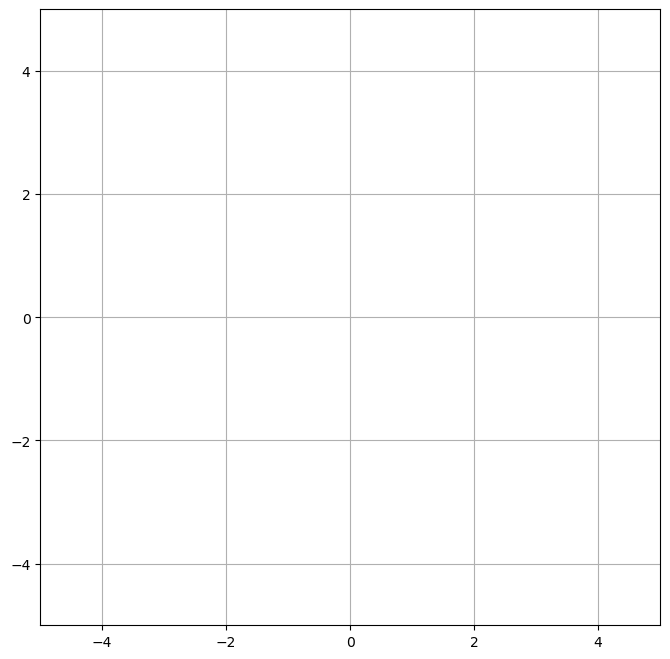

In [60]:
# make animation
def animate(i):
    ln1.set_data([xe[i], xs[i]], [ye[i], ys[i]])
    text.set_text('Time = {:.2f} Years'.format(i*tt))
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.grid()
ln1, = plt.plot([], [], 'ro--', lw=3, markersize=8)
text = plt.text(0.7, 0.7, '')
ax.set_ylim(-5, 5)
ax.set_xlim(-5,5)
ani = animation.FuncAnimation(fig, animate, frames=200, interval=50)
# ani.save('2body.gif',writer='pillow',fps=30)

# 3-Body

This is generic code for simulating the orbits of 3 bodies, given 
1. each of their masses
2. each of their initial positions
3. each of their initial velocities

So technically, we could play around with these parameters and observe hypothetically how the masses would orbit each other/fling each other away

The simulation I have provided below is with special initial conditions to obtain periodic, stable-ish solutions at least for the length of the gif lol (which are quite rare). These special initial conditions were found in the following scientific papers
- https://arxiv.org/pdf/1303.0181.pdf
- https://arxiv.org/pdf/1709.04775.pdf

In summary, they studied the 3-Body problem with these parameters:

- $m_1 = m_2 = 1$
- At $t = 0$, the initial conditions $x_1 = -x_2 = -1$ and $x_3 = 0$
- At $t = 0$, the initial conditions $y_1 = y_2 = y_3 = 0$
- At $t = 0$, the initial conditions $v_{x1} = v_{x2} = v_1$, where $v_1$ is some defined speed
- At $t = 0$, the initial conditions $v_{y1} = v_{y2} = v_2$, where $v_2$ is some defined speed
- At $t = 0$ the initial conditions $v_{x3} = -\frac{2v_1}{m_3}$ and $v_{y3} = -\frac{2v_2}{m_3}$

There are only three free parameters:
- $v_1$
- $v_2$
- $m_3$

We will be using parameters from paper 2: $v_1 = 0.9911981217$, $v_2 = 0.7119472124$ and $m_3 = 4$ for the simulation below.

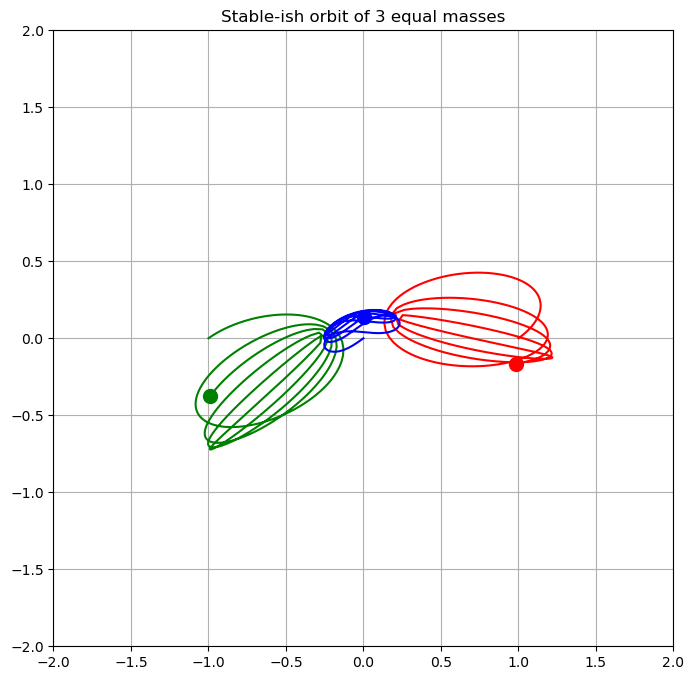

In [62]:
m3 = 4
v1 = 0.9911981217
v2 = 0.7119472124

# Everything else follows from paper
m1 = 1
m2 = 1 
m3 = m3
x1_0 = -1
y1_0 = 0
x2_0 = 1
y2_0 = 0
x3_0 = 0
y3_0 = 0
vx1_0 =  v1
vy1_0 =  v2
vx2_0 = v1
vy2_0 = v2
vx3_0 = -2*v1/m3
vy3_0 = -2*v2/m3


def dSdt2(S, t): #S is a matrix that contains all the parameters
    x1, y1, x2, y2, x3, y3, vx1, vy1, vx2, vy2, vx3, vy3 = S
    r_12 = np.sqrt((x1-x2)**2 + (y1-y2)**2) #distance between sun and earth
    r_13 = np.sqrt((x1-x3)**2 + (y1-y3)**2) #distance between sun and moon
    r_23 = np.sqrt((x2-x3)**2 + (y2-y3)**2) #distance between earth and moon
    return [vx1, vy1, vx2, vy2, vx3, vy3,
           (-m2/(r_12**3))*(x1-x2) + (-m3/(r_13**3))*(x1-x3), #for sun x component
           (-m2/(r_12**3))*(y1-y2) + (-m3/(r_13**3))*(y1-y3), #for sun y component
           (-m1/(r_12**3))*(x2-x1) + (-m3/(r_23**3))*(x2-x3), #for earth x component
           (-m1/(r_12**3))*(y2-y1) + (-m3/(r_23**3))*(y2-y3), #for earth y component
           (-m1/(r_13**3))*(x3-x1) + (-m2/(r_23**3))*(x3-x2), #for moon x component
           (-m1/(r_13**3))*(y3-y1) + (-m2/(r_23**3))*(y3-y2)] #for moon y component


time = np.linspace(0, 20, 3000)

sol1 = sp.odeint(dSdt2, y0=[x1_0, y1_0, x2_0, y2_0, x3_0, y3_0, vx1_0, vy1_0, vx2_0, vy2_0, vx3_0, vy3_0],
                     t=time)

x1 = sol1.T[0]
y1 = sol1.T[1]
x2 = sol1.T[2]
y2 = sol1.T[3]
x3 = sol1.T[4]
y3 = sol1.T[5]

historyx1 = []
historyx2 = []
historyx3 = []
historyy1 = []
historyy2 = []
historyy3 = []

def animate(i):
    ln1.set_data(x1[i], y1[i])
    ln2.set_data(x2[i], y2[i])
    ln3.set_data(x3[i], y3[i])
    plt.title('Stable-ish orbit of 3 equal masses')
    if i == 0:
        historyx1.clear()
        historyx2.clear()
        historyx3.clear()
        historyy1.clear()
        historyy2.clear()
        historyy3.clear()
    historyx1.append(x1[i])
    historyx2.append(x2[i])
    historyx3.append(x3[i])
    historyy1.append(y1[i])
    historyy2.append(y2[i])
    historyy3.append(y3[i])
    trace1.set_data(historyx1, historyy1)
    trace2.set_data(historyx2, historyy2)
    trace3.set_data(historyx3, historyy3)
    
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.grid()
ln1, = plt.plot([], [], 'go', lw=3, markersize= 10)
ln2, = plt.plot([], [], 'ro', lw=3, markersize = 10)
ln3, = plt.plot([], [], 'bo', lw=3, markersize = 10)
trace1, = plt.plot([], [], color = 'green')
trace2, = plt.plot([], [], color = 'red')
trace3, = plt.plot([], [], color = 'blue')

ax.set_ylim(-2, 2)
ax.set_xlim(-2,2)
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
# ani.save('plan.gif',writer='pillow',fps=30, dpi = 150)

